In [6]:
import numpy as np
import pandas as pd 
import SimpleITK as sitk
import numpy as np
import torch
from torchvision import transforms
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split



In [7]:
# Define the path for the dataset
train_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'

# Load CSV files
train_df = pd.read_csv(os.path.join(train_path, 'train.csv'))
label_df = pd.read_csv(os.path.join(train_path, 'train_label_coordinates.csv'))
train_description_df = pd.read_csv(os.path.join(train_path, 'train_series_descriptions.csv'))
test_description_df = pd.read_csv(os.path.join(train_path, 'test_series_descriptions.csv'))
submission_df = pd.read_csv(os.path.join(train_path, 'sample_submission.csv'))

In [8]:
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        
        # List images in the series directory
        images = os.listdir(series_dir)
        # Create full paths for each image
        image_paths.extend([os.path.join(series_dir, img) for img in images])
        
    return image_paths

In [9]:
import os
import pandas as pd

# Assuming your previous functions and imports are already in place

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_description_df, os.path.join(train_path, 'train_images'))
test_image_paths = generate_image_paths(test_description_df, os.path.join(train_path, 'test_images'))

# Print to verify paths
print("Train Image Paths:")
print(train_image_paths[:5])  # Print the first 5 train image paths

print("\nTest Image Paths:")
print(test_image_paths[:5])  # Print the first 5 test image paths


Train Image Paths:
['/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/12.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/9.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/14.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/11.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/10.dcm']

Test Image Paths:
['/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/12.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/18.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/9.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/22.dcm', '/ka

In [10]:
# Initialize a list to hold the structured data
structured_df = []

# Iterate through each row in the train DataFrame
for _, row in train_df.iterrows():
    # Initialize a dictionary to hold data for the current row
    df = {
        'study_id': [],
        'condition': [],
        'level': [],
        'severity': []
    }
    
    # Iterate through the columns in the current row
    for column, value in row.items():
        # Skip specific columns that do not contribute to the structured data
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            # Split the column name to get condition and level
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])  # Construct condition name
            level = f"{parts[-2].capitalize()}/{parts[-1].capitalize()}"  # Construct level

            # Append the data to the dictionary
            df['study_id'].append(row['study_id'])
            df['condition'].append(condition)
            df['level'].append(level)
            df['severity'].append(value)
    
    # Append the dictionary as a DataFrame to the structured_df list
    structured_df.append(pd.DataFrame(df))

# all individual DataFrames into a single DataFrame
structured_df = pd.concat(structured_df, ignore_index=True)

# Display the structured DataFrame
structured_df.head()


,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [11]:
# First merge: structured_df with label
merged_df = pd.merge(structured_df, label_df, on=['study_id', 'condition', 'level'], how='inner')

# Second merge: merged_df with train_description
final_df = pd.merge(merged_df, train_description_df, on=['series_id', 'study_id'], how='inner')

# Display the first few rows of the final DataFrame
final_df.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [12]:
final_df['severity'].value_counts()


severity
Normal/Mild    37626
Moderate        7950
Severe          3081
Name: count, dtype: int64

In [13]:
# Identify NaN values
print("NaN values in each column:")
print(final_df.isnull().sum())


# Dropping rows with NaN values 
final_df = final_df.dropna()

print("After dropping NaN values:")
final_df.isnull().sum()



NaN values in each column:
study_id               0
condition              0
level                  0
severity              35
series_id              0
instance_number        0
x                      0
y                      0
series_description     0
dtype: int64
After dropping NaN values:


study_id              0
condition             0
level                 0
severity              0
series_id             0
instance_number       0
x                     0
y                     0
series_description    0
dtype: int64

In [14]:
# Mapping severity levels
final_df['severity'] = final_df['severity'].map({
    'Normal/Mild': 'normal_mild', 
    'Moderate': 'moderate', 
    'Severe': 'severe'
})

# Optionally, handle NaN values that might result from mapping
final_df['severity'] = final_df['severity'].fillna('unknown')  # Fill NaN with 'unknown' if needed

# Display the updated DataFrame with severity levels
print("Dataframe with severity levels:")
final_df.head()


Dataframe with severity levels:


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [15]:
# Creating a unique row_id
final_df['row_id'] = (
    final_df['study_id'].astype(str) + '_' +
    final_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_df['level'].str.lower().str.replace('/', '_')
)

final_df.sample(3)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id
10202,919752232,Left Neural Foraminal Narrowing,L3/L4,normal_mild,3587137253,4,250.606572,281.026166,Sagittal T1,919752232_left_neural_foraminal_narrowing_l3_l4
9904,893004686,Spinal Canal Stenosis,L4/L5,severe,2233709875,12,213.805880,276.844596,Sagittal T2/STIR,893004686_spinal_canal_stenosis_l4_l5
39387,3478119785,Spinal Canal Stenosis,L2/L3,normal_mild,3677055363,11,243.836232,221.048780,Sagittal T2/STIR,3478119785_spinal_canal_stenosis_l2_l3


## Creating the Image Path Column



In [16]:
# Creating the image_path column
final_df['image_path'] = (
    train_path + '/train_images/' + 
    final_df['study_id'].astype(str) + '/' +
    final_df['series_id'].astype(str) + '/' +
    final_df['instance_number'].astype(str) + '.dcm'
)

# Display the updated DataFrame with the new image_path
final_df.sample(3)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
38457,3390414227,Left Subarticular Stenosis,L2/L3,normal_mild,2491116591,19,175.698113,176.000000,Axial T2,3390414227_left_subarticular_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
39161,3462160059,Spinal Canal Stenosis,L1/L2,normal_mild,279953719,8,216.347826,99.652174,Sagittal T2/STIR,3462160059_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
36364,3215006480,Left Subarticular Stenosis,L5/S1,normal_mild,351146847,22,208.390484,182.941709,Axial T2,3215006480_left_subarticular_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


## Visualizing DICOM Images with Markers


Visualizing Original Training Images with Markers:


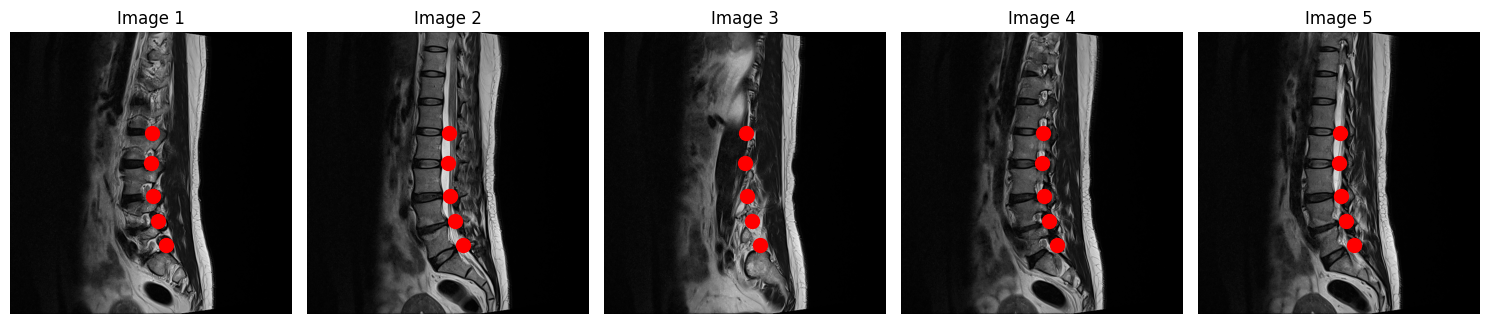

Visualizing Original Testing Images with Markers:


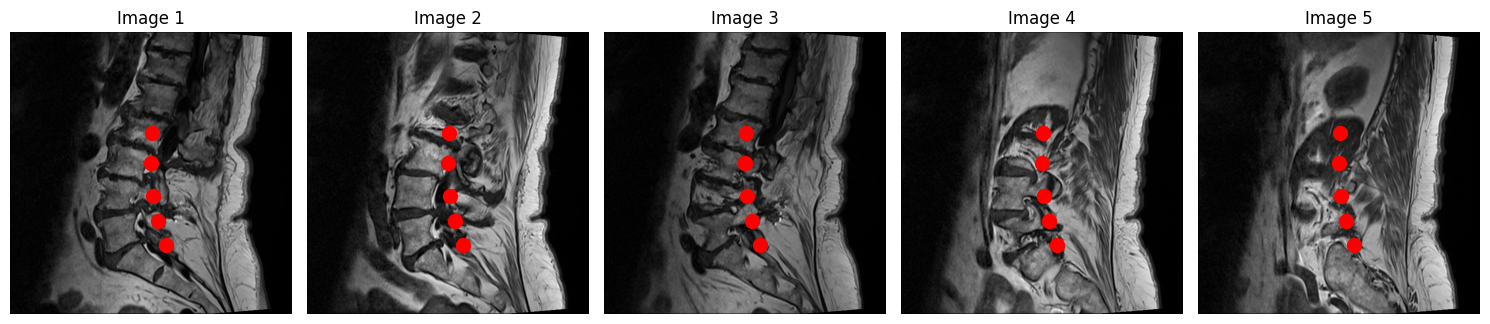

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image

# Function to visualize a set of images with markers
def visualize_images(image_paths, final_df, study_id, series_id, num_images=5):
    plt.figure(figsize=(15, 10))
    
    # Extract marker coordinates for the specified study_id and series_id
    markers = final_df[(final_df['study_id'] == study_id) & (final_df['series_id'] == series_id)]
    
    # Loop through the number of images to display
    for i in range(num_images):
        # Load the DICOM image using SimpleITK
        image = sitk.ReadImage(image_paths[i])
        image_array = sitk.GetArrayFromImage(image)  # Convert to NumPy array
        image_array = np.squeeze(image_array)  # Remove single-dimensional entries
        
        # Convert NumPy array to PIL Image
        pil_image = Image.fromarray(image_array)

        # Plotting the original image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(pil_image, cmap='gray')  # Display as grayscale
        
        # Overlay markers
        if not markers.empty:
            plt.scatter(markers['x'], markers['y'], c='red', s=100, label='Markers', marker='o')
        
        plt.axis('off')  # Hide axis
        plt.title(f'Image {i + 1}')
    
    plt.tight_layout()
    plt.show()

# Example usage
# Visualize original training images with markers for a specific study_id and series_id
study_id = 4003253  # Example study_id
series_id = 702807833  # Example series_id

print("Visualizing Original Training Images with Markers:")
visualize_images(train_image_paths, final_df, study_id, series_id, num_images=5)

# Visualize original testing images (if desired)
print("Visualizing Original Testing Images with Markers:")
visualize_images(test_image_paths, final_df, study_id, series_id, num_images=5)


In [18]:
# Check for duplicate rows
duplicates = final_df[final_df.duplicated()]

# Count the number of duplicate rows
num_duplicates = duplicates.shape[0]

# Display the duplicate rows and count
if num_duplicates > 0:
    print("Duplicate rows found:")
    print(duplicates)
    print(f"\nTotal number of duplicate rows: {num_duplicates}")
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [19]:
# Checking the counts for each severity level
severity_counts = final_df['severity'].value_counts()

# Displaying the counts
print("Severity Counts:")
print(severity_counts)


Severity Counts:
severity
normal_mild    37626
moderate        7950
severe          3081
Name: count, dtype: int64


In [20]:
from sklearn.utils import class_weight
import numpy as np

# Get the unique classes and their corresponding frequencies
classes = final_df['severity'].unique()
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Automatically adjusts weights inversely proportional to class frequencies
    classes=classes,
    y=final_df['severity']
)

# Create a dictionary mapping class labels to weights
class_weight_dict = dict(zip(classes, class_weights))

print("Class Weights:", class_weight_dict)



Class Weights: {'normal_mild': 0.4310583107425716, 'moderate': 2.040125786163522, 'severe': 5.264199935086011}


In [21]:
import pydicom
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

def load_image(self, image_path):
    """Load an image from a DICOM file or an augmented image."""
    if image_path.lower().endswith('.dcm'):
        # Load DICOM file
        dicom = pydicom.dcmread(image_path, force=True)
        image = dicom.pixel_array
    else:
        # Load augmented image (assumed to be in a format like PNG or JPEG)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            raise FileNotFoundError(f"Could not load image from {image_path}")

    # Convert to a format suitable for processing (e.g., uint8)
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    # Convert grayscale to RGB
    if len(image.shape) == 2:  # Grayscale image
        image = np.stack([image] * 3, axis=-1)  # Repeat the channel

    return image



# Custom Dataset Class for DICOM Image Loading

In this section, we define a `CustomDataset` class that inherits from PyTorch's `Dataset` class. This class is designed to load DICOM images and their corresponding severity labels from a provided DataFrame. It incorporates image loading, processing, and transformation functionalities necessary for training deep learning models.

## Class Overview

The `CustomDataset` class serves the following purposes:
- Loads images from DICOM files or augmented formats.
- Handles grayscale images by converting them to RGB.
- Applies transformations to images (e.g., normalization, resizing).
- Returns the corresponding severity labels for each image.

## Implementation


In [23]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform


    def __len__(self):
        return len(self.dataframe)  # Ensure this returns the correct length

    def load_image(self, image_path):
        """Load an image from a DICOM file or an augmented image."""
        if image_path.lower().endswith('.dcm'):
            # Load DICOM file
            dicom = pydicom.dcmread(image_path, force=True)
            image = dicom.pixel_array
        else:
            # Load augmented image (assumed to be in a format like PNG or JPEG)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if image is None:
                raise FileNotFoundError(f"Could not load image from {image_path}")

        # Convert to a format suitable for processing (e.g., uint8)
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        # Convert grayscale to RGB if the image has a single channel
        if len(image.shape) == 2:  # Check if the image is grayscale
            image = np.stack([image] * 3, axis=-1)  # Repeat the channel to make it RGB

        return image

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'].iloc[index]
        label = self.dataframe['severity'].iloc[index]
        
        # Load the image
        image = self.load_image(image_path)
        if image is None:
            image = np.zeros((224, 224), dtype=np.uint8)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Ensure the label is a tensor or return as-is
        label = torch.tensor(label) if isinstance(label, (int, float)) else label

        return image, label

In [24]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert array to PIL Image
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomRotation(degrees=(-15, 15)),  # Random rotation between -15° and 15°
    transforms.RandomAffine(degrees=0, shear=(15, 15)),  # Apply shear transformation
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor and normalize to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])


In [25]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Splitting the Dataset into Training and Validation Sets



In [26]:
train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=42)

In [28]:

val_dataset = CustomDataset(val_df, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# start validations

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class UnifiedEfficientNetV2(nn.Module):
    def __init__(self, num_classes=3, pretrained=True, weights_path=None):
        super(UnifiedEfficientNetV2, self).__init__()

        # Load the EfficientNetV2 with optional pretrained weights
        self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT if pretrained else None)

        # Load local weights if a path is provided
        if weights_path is not None:
            self.model.load_state_dict(torch.load(weights_path))

        # Capture in_features from the last layer of the original classifier
        in_features = self.model.classifier[-1].in_features  # Should be 1280 for EfficientNetV2-S
        
        # Replace the classifier with an identity function (we'll handle classification manually)
        self.model.classifier = nn.Identity()

        # Define fully connected layers with BatchNorm and ReLU activation
        self.fc1 = nn.Sequential(
            nn.Linear(in_features, 256),  # Update input size to 1280
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout layers for regularization
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.3)

    def forward(self, x):
        # Get embeddings from EfficientNetV2
        embeddings = self.model(x)  # Should output shape (batch_size, 1280)

        # Fully connected layers with dropout and activations
        x = self.fc1(embeddings)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x




In [34]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the saved model
model_path = '/kaggle/input/full-model-30epoch/pytorch/default/1/full_model30epochs.pth'  
  

# Load the entire model
unified_model = torch.load(model_path)
unified_model.to(device)
print("Full model loaded.")
class_weights_tensor = torch.tensor(list(class_weight_dict.values())).float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

/tmp/ipykernel_30/2147750005.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unified_model = torch.load(model_path)


Full model loaded.


In [35]:
import torch
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the evaluation function
def evaluate_model(model, valloader, len_val, criterion, output_dir='./'):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Label mapping dictionary
    mapping_labels = {
        'normal_mild': 0,
        'moderate': 1,
        'severe': 2
    }
    
    # Initialize lists to store validation data for ROC and confusion matrix
    all_val_labels = []
    all_val_probs = []
    all_val_preds = []
    
    # Set model to evaluation mode
    model.eval()
    
    val_loss = 0.0
    correct_val = 0
    
    with torch.no_grad():  # Disable gradient calculations during evaluation
        for images, labels in valloader:
            images = images.to(device)
            labels = torch.tensor([mapping_labels[label] for label in labels], dtype=torch.long).to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
            correct_val += (predicted == labels).sum().item()
            
            # Collect probabilities, true labels, and predictions for metrics
            all_val_labels.append(labels.cpu().numpy())
            all_val_probs.append(probabilities.cpu().numpy())
            all_val_preds.append(predicted.cpu().numpy())
    
    # Aggregate ROC and confusion matrix data
    all_val_labels = np.concatenate(all_val_labels)
    all_val_probs = np.concatenate(all_val_probs)
    all_val_preds = np.concatenate(all_val_preds)
    
    # Calculate validation accuracy
    val_acc = 100 * correct_val / len_val
    val_loss /= len(valloader)
    
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
    
    # Plot ROC Curve
    plot_roc_curve(all_val_labels, all_val_probs, output_dir)

    # Plot Confusion Matrix
    plot_confusion_matrix(all_val_labels, all_val_preds, output_dir)

    # Print Classification Report
    print_classification_report(all_val_labels, all_val_preds)

# Function to plot the ROC curve
def plot_roc_curve(true_labels, probs, output_dir):
    num_classes = probs.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and ROC area for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['blue', 'green', 'red']
    class_names = ['normal_mild', 'moderate', 'severe']
    
    for i, color in enumerate(colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Save the ROC curve
    roc_path = os.path.join(output_dir, 'roc_curve.png')
    plt.savefig(roc_path)
    plt.close()
    print(f"ROC curve saved to {roc_path}")

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, preds, output_dir):
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal_mild', 'moderate', 'severe'], 
                yticklabels=['normal_mild', 'moderate', 'severe'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Save the confusion matrix plot
    cm_path = os.path.join(output_dir, 'confusion_matrix.png')
    plt.savefig(cm_path)
    plt.close()
    print(f"Confusion matrix saved to {cm_path}")

# Function to print classification report
def print_classification_report(true_labels, preds):
    class_names = ['normal_mild', 'moderate', 'severe']
    report = classification_report(true_labels, preds, target_names=class_names)
    print("Classification Report:\n", report)

Val Loss: 0.8372, Val Accuracy: 74.66%


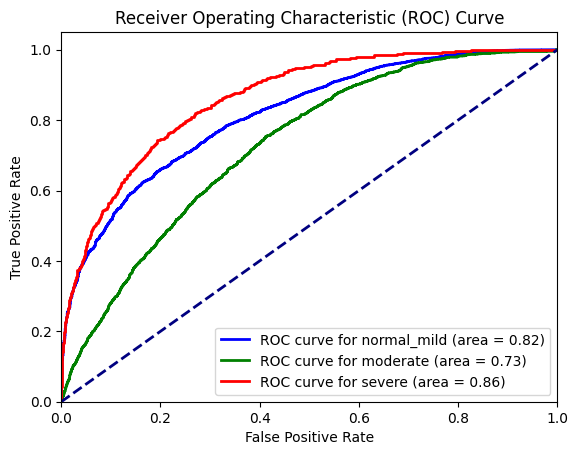

ROC curve saved to ./evaluation_outputs/roc_curve.png


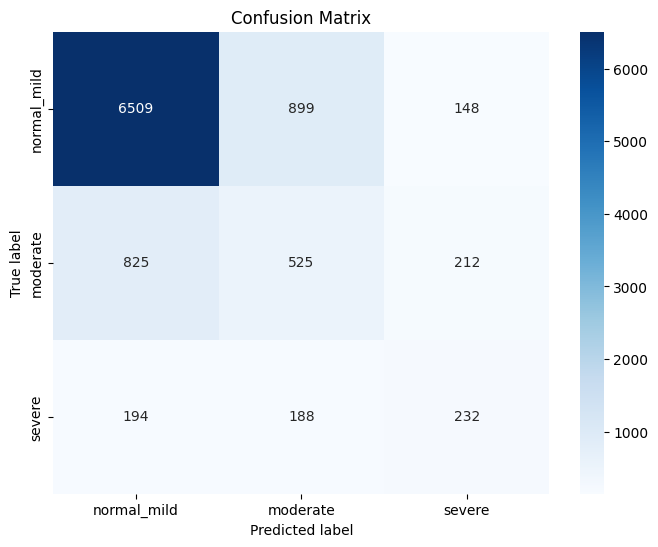

Confusion matrix saved to ./evaluation_outputs/confusion_matrix.png
Classification Report:
               precision    recall  f1-score   support

 normal_mild       0.86      0.86      0.86      7556
    moderate       0.33      0.34      0.33      1562
      severe       0.39      0.38      0.38       614

    accuracy                           0.75      9732
   macro avg       0.53      0.53      0.53      9732
weighted avg       0.75      0.75      0.75      9732



In [37]:
# Assuming 'val_loader' is your validation dataloader, calculate len_val
len_val = len(val_loader.dataset)  # or use len(val_loader) * batch_size

# Call the evaluation function
evaluate_model(unified_model, val_loader, len_val, criterion, output_dir='./evaluation_outputs')


## Evaluation Insights

### 1. **Confusion Matrix**

The confusion matrix reveals the classification performance across three categories: "normal_mild," "moderate," and "severe." Here's what we can observe from the matrix:

- **Normal_mild (True Positive: 6509)**: The model is most accurate in predicting this class, with a strong classification rate (86%). Misclassifications mostly occur with 899 samples being predicted as "moderate" and 148 as "severe."
- **Moderate (True Positive: 525)**: Performance is weakest for the "moderate" class. There are significant misclassifications, with 825 samples predicted as "normal_mild" and 212 as "severe."
- **Severe (True Positive: 232)**: While the model is better at detecting severe cases compared to "moderate," it still struggles, misclassifying 194 as "normal_mild" and 188 as "moderate."

The confusion matrix reflects the class imbalance, with the model favoring the "normal_mild" class due to the larger number of samples.

### 2. **Classification Report**

- **Normal_mild**: High precision (0.86) and recall (0.86) indicate the model is performing very well in identifying and correctly classifying "normal_mild" samples. The F1-score is equally strong at 0.86.
- **Moderate**: Precision and recall are both quite low (0.33 and 0.34, respectively), which signifies the difficulty the model has in correctly identifying this category.
- **Severe**: Precision is 0.39, indicating that when the model predicts "severe," it's correct 39% of the time. The recall (0.38) reflects that the model identifies 38% of actual severe cases, which leaves room for improvement.

Overall, the **accuracy is 75%**, which reflects the model's ability to classify the majority class ("normal_mild") well, but struggles with the minority classes ("moderate" and "severe"). The **macro average** of precision, recall, and F1-score shows a 0.53 average performance, indicating significant class imbalance.

### 3. **ROC Curve Analysis**

The ROC curves for each class give insight into the model's discriminatory ability across the different categories:

- **Normal_mild (AUC = 0.82)**: The model shows a strong ability to distinguish "normal_mild" from other classes. The AUC of 0.82 indicates good performance, but some overlap with other classes remains.
- **Moderate (AUC = 0.73)**: Moderate cases are the most difficult to distinguish, as reflected in the lower AUC. This is also consistent with the low precision and recall in the classification report.
- **Severe (AUC = 0.86)**: The model performs well in identifying "severe" cases compared to the other classes, with an AUC of 0.86, though misclassifications are still present.

Overall, while the ROC AUC scores show decent performance for "normal_mild" and "severe," the "moderate" class struggles, both in precision-recall metrics and its ROC curve.


----------